In [105]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet
import torch

In [144]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
DATAROOT = 'data/sets/nuscenes'
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)
mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
mini_train[:5]
# print(len(mini_train[1]))

# Hannes BELOW
dim1 = len(mini_train)
dim2 = len(mini_train[0])
# dim3 = len(mini_train[0][0])
# dim4 = len(mini_train[0][0][0])

print(dim1, dim2) #, dim3, dim4)


mini_val = get_prediction_challenge_split("mini_val", dataroot=DATAROOT)
mini_val[:5]

dim1 = len(mini_val)
dim2 = len(mini_val[0])
# dim3 = len(mini_val[0][0])
# dim4 = len(mini_val[0][0][0])

print(dim1, dim2) #, dim3, dim4)
print(mini_val)

# FOR SHORT TEST
# mini_train = mini_train[1:50]

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.280 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
742 65
61 65
['dc762bf1bc694d3e8141bf592f9b1456_c5f58c19249d4137ae063b0e9ecd8b8e', 'dc762bf1bc694d3e8141bf592f9b1456_700c1a25559b4433be532de3475e58a9', 'dc762bf1bc694d3e8141bf592f9b1456_747aa46b9a4641fe90db05d97db2acea', 'dc762bf1bc694d3e8141bf592f9b1456_f4f86af4da3b49e79497deda5c5f223a', 'dc762bf1bc694d3e8141bf592f9b1456_6832e717621341568c759151b5974512', 'dc762bf1bc694d3e8141bf592f9b1456_c59e60042a8643e899008da2e446acca', 'dc762bf1bc694d3e8141bf592f9b1456_fa65a298c01f44e7a182bbf9e5fe3697', 'dc762bf1bc694d3e8141bf592f9b1456_a98fba72bde9433fb882032d18aedb2e', 'dc762bf1bc694d3e8141bf592f9b1456_b6b0d9f2f2e14a3aaa2c8aedeb1edb69', 'dc762bf1bc694d3e8141bf592f9b1456_796b1988

In [107]:
from nuscenes.prediction import PredictHelper
helper = PredictHelper(nuscenes)

In [126]:
# instance_token, sample_token = mini_train[0].split("_")

instance_token_list = [None] * len(mini_train)
sample_token_list = [None] * len(mini_train)
future_xy_local_list = [None] * len(mini_train)# * 6

for index, value in enumerate(mini_train):
# for object in range(len(mini_train)):
    instance_token_list[index], sample_token_list[index] = value.split("_")
    # instance_token_list[index], sample_token_list[index] = mini_train[index].split("_")

    future_xy_local_list[index] = helper.get_future_for_agent(instance_token_list[index], sample_token_list[index], seconds=6, in_agent_frame=True)
    

# instance_token_list, sample_token_list =  mini_train[:].split("_")


test_index = 0
instance_token_list[test_index]
sample_token_list[test_index]
future_xy_local_list[test_index]

dim1 = len(future_xy_local_list)
dim2 = len(future_xy_local_list[0])
dim3 = len(future_xy_local_list[0][0])

print(dim1, dim2, dim3)#, dim4)

future_xy_local_list[test_index]


742 12 2


array([[ 1.07506273e-02,  2.43494197e-01],
       [-2.04636663e-01,  1.20515386e+00],
       [-2.03985834e-01,  2.57851309e+00],
       [-2.58677570e-01,  4.50313379e+00],
       [-3.13590878e-01,  6.67620961e+00],
       [-3.14041468e-01,  9.67727022e+00],
       [-4.23742684e-01,  1.26777826e+01],
       [-4.23596358e-01,  1.58444471e+01],
       [-3.67689864e-01,  1.87633379e+01],
       [-2.61820748e-02,  2.20066989e+01],
       [ 5.33470874e-01,  2.52126742e+01],
       [ 1.43481063e+00,  2.84013252e+01]])

/home/hannes-ubuntu/anaconda3/envs/nuscenesNew/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/hannes-ubuntu/anaconda3/envs/nuscenesNew/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


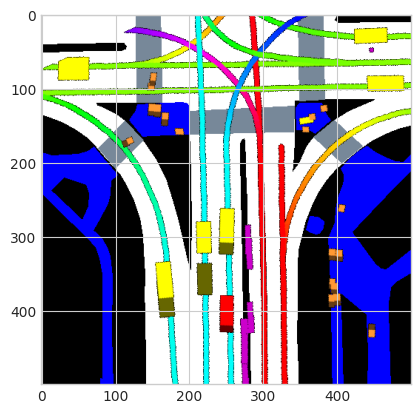

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=2) # Hannes (seconds_of_history)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

img_list = [None] * len(mini_train)
for index in range(len(mini_train)):
    # instance_token_img, sample_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6', '7626dde27d604ac28a0240bdd54eba7a'
    instance_token_img = instance_token_list[index]
    sample_token_img = sample_token_list[index]
    anns = [ann for ann in nuscenes.sample_annotation if ann['instance_token'] == instance_token_img]
    img_list[index] = mtp_input_representation.make_input_representation(instance_token_img, sample_token_img)

# plt.imshow(img)
test_index = 0
plt.imshow(img_list[test_index])

In [132]:
agent_state_vector_list = [None] * len(mini_train)
for index in range(len(mini_train)):
    instance_token_img = instance_token_list[index]
    sample_token_img = sample_token_list[index]
    agent_state_vector_list[index] = torch.Tensor([[helper.get_velocity_for_agent(instance_token_img, sample_token_img),
                                    helper.get_acceleration_for_agent(instance_token_img, sample_token_img),
                                    helper.get_heading_change_rate_for_agent(instance_token_img, sample_token_img)]])

agent_state_vector at index 1: tensor([[ 0.4430, -2.2965,  0.0000]])
future_xy_local at index 1: [[-0.21538729  0.96165967]
 [-0.21473646  2.3350189 ]
 [-0.2694282   4.25963959]
 [-0.32434151  6.43271541]
 [-0.32479209  9.43377603]
 [-0.43449331 12.43428842]
 [-0.43434699 15.60095291]
 [-0.37844049 18.5198437 ]
 [-0.0369327  21.76320468]
 [ 0.52272025 24.96917997]
 [ 1.42406    28.15783104]
 [ 2.99607452 31.55143906]]


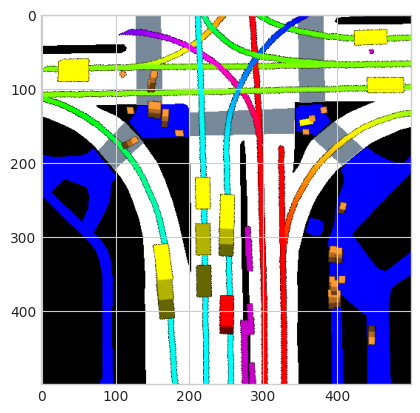

In [142]:
test_index = 1 #Den ser ut att bryta mellan 108 och 109 exempelvis

plt.imshow(img_list[test_index])
print(f"agent_state_vector at index {test_index}: {agent_state_vector_list[test_index]}")
print(f"future_xy_local at index {test_index}: {future_xy_local_list[test_index]}")

In [112]:
# # for index, value in enumerate(mini_train):
# for img in img_list:
#     # im = plt.imread(f)
#     # if img is None:
#     #     img = plt.imshow(im)
#     #     plt.pause(0.5)
#     # else:
#     #     img.set_data(im)
#     plt.imshow(img)
#     plt.pause(0.1)
#     plt.draw()

import cv2
import numpy as np

def create_video(images, output_filename, fps=2):
    height, width, _ = images[0].shape
    size = (width, height)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    out = cv2.VideoWriter(output_filename, fourcc, fps, size)

    for image in images:
        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        out.write(img)

    out.release()

# images = [...]  # Your list of images
images = img_list  # Your list of images
create_video(images, 'output_video_2fps_dt2_50.avi')


# print(img_list)

In [113]:
## DOES NOT WORK
# import cv2

# def play_video(video_filename):
#     cap = cv2.VideoCapture(video_filename)

#     while cap.isOpened():
#         ret, frame = cap.read()

#         if not ret:
#             break

#         cv2.imshow('Video', frame)

#         # Press 'q' to exit the video playback
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# video_filename = 'output_video.avi'
# play_video(video_filename)


In [114]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)

nusc.list_scenes()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.661 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.
scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parki

In [115]:
my_scene = nusc.scene[0]
my_scene
first_sample_token = my_scene['first_sample_token']
first_sample_token
my_sample = nusc.get('sample', first_sample_token)
my_sample['data']
my_annotation_token = my_sample['anns'][11]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

{'token': '02248ff567e3497c957c369dc9a1bd5c',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '91f0f127e46a49829700247cf534d9fd',
 'visibility_token': '4',
 'attribute_tokens': ['ab83627ff28b465b85c427162dec722f'],
 'translation': [417.399, 1193.55, 0.994],
 'size': [1.019, 0.915, 1.67],
 'rotation': [0.19253052991251002, 0.0, 0.0, 0.9812909838837857],
 'prev': '',
 'next': 'f7bd5e1eb03d42129d3028556126550c',
 'num_lidar_pts': 7,
 'num_radar_pts': 3,
 'category_name': 'human.pedestrian.adult'}

In [137]:
from collections import Counter

# instance_token_list sample_token_list

input_list = instance_token_list

# Count the occurrences of each string in the list
string_counts = Counter(input_list)

# Initialize an empty list to store the indices of items with a count greater than 35
selected_indices = []

# Iterate over the list and save the index if the count of the item is greater than 35
for index, item in enumerate(input_list):
    # if string_counts[item] > 24:
    if string_counts[item] > 4:
        selected_indices.append(index)

print(selected_indices)
filtered_instance_tokens = []
filtered_sample_tokens = []
[filtered_instance_tokens.append(instance_token_list[index]) for index in selected_indices]
[filtered_sample_tokens.append(sample_token_list[index]) for index in selected_indices]
print(filtered_instance_tokens)
print(filtered_sample_tokens)

num_unique_strings = len(set(input_list[index] for index in selected_indices))
print("Number of unique strings:", num_unique_strings)




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 

In [140]:
# print(filtered_instance_tokens)
print(mini_train)

['bc38961ca0ac4b14ab90e547ba79fbb6_39586f9d59004284a7114a68825e8eec', 'bc38961ca0ac4b14ab90e547ba79fbb6_356d81f38dd9473ba590f39e266f54e5', 'bc38961ca0ac4b14ab90e547ba79fbb6_e0845f5322254dafadbbed75aaa07969', 'bc38961ca0ac4b14ab90e547ba79fbb6_c923fe08b2ff4e27975d2bf30934383b', 'bc38961ca0ac4b14ab90e547ba79fbb6_f1e3d9d08f044c439ce86a2d6fcca57b', 'bc38961ca0ac4b14ab90e547ba79fbb6_4f545737bf3347fbbc9af60b0be9a963', 'bc38961ca0ac4b14ab90e547ba79fbb6_7626dde27d604ac28a0240bdd54eba7a', 'bc38961ca0ac4b14ab90e547ba79fbb6_be99ffc878b24aca8956bbb4e0f97d0c', 'bc38961ca0ac4b14ab90e547ba79fbb6_9813c23a5f1448b09bb7910fea9baf20', 'bc38961ca0ac4b14ab90e547ba79fbb6_023c4df2d451409881d8e6ea82f14704', 'a60047adc78a4b6895702e86b6d2fe88_39586f9d59004284a7114a68825e8eec', 'a60047adc78a4b6895702e86b6d2fe88_356d81f38dd9473ba590f39e266f54e5', 'a60047adc78a4b6895702e86b6d2fe88_e0845f5322254dafadbbed75aaa07969', 'a60047adc78a4b6895702e86b6d2fe88_c923fe08b2ff4e27975d2bf30934383b', 'a60047adc78a4b6895702e86b6d2fe88